In [47]:
import glob 
import numpy as np 
import os 
import shutil 

from keras_preprocessing.image import ImageDataGenerator,  load_img, img_to_array, array_to_img 
np.random.seed(42) 

import matplotlib.pyplot as plt 

In [26]:
files= glob.glob('C:/Users/hecto/Downloads/MachineCrypto/Proyecto/dataset/Xray-covid/*')
files2=glob.glob('C:/Users/hecto/Downloads/MachineCrypto/Proyecto/dataset/Xray-sanos/*')

In [40]:
COVID_files = [fn for fn in files if 'covid' in fn] 
HEALTHY_files = [fn for fn in files2 if 'sanos' in fn] 
len(COVID_files),len(HEALTHY_files)

(132, 137)

In [41]:
COVID_train = np.random.choice(COVID_files, size=100, replace=False) 
HEALTHY_train = np.random.choice(HEALTHY_files, size=100, replace=False) 
COVID_files = list(set(COVID_files) - set(COVID_train)) 
HEALTHY_files = list(set(HEALTHY_files) - set(HEALTHY_train)) 
 
COVID_val = np.random.choice(COVID_files, size=20, replace=False) 
HEALTHY_val = np.random.choice(HEALTHY_files, size=20, replace=False) 
COVID_files = list(set(COVID_files) - set(COVID_val)) 
HEALTHY_files = list(set(HEALTHY_files) - set(HEALTHY_val)) 
 
COVID_test = np.random.choice(COVID_files, size=12, replace=False) 
HEALTHY_test = np.random.choice(HEALTHY_files, size=17, replace=False) 
 
print('COVID datasets:', COVID_train.shape, COVID_val.shape, COVID_test.shape) 
print('HEALTHY datasets:', HEALTHY_train.shape, HEALTHY_val.shape, HEALTHY_test.shape) 

COVID datasets: (100,) (20,) (12,)
HEALTHY datasets: (100,) (20,) (17,)


In [96]:
train_dir = 'data/training_data' 
val_dir = 'data/validation_data' 
test_dir = 'data/test_data' 
 
    
train_files = np.concatenate([COVID_train, HEALTHY_train]) 
validate_files = np.concatenate([COVID_val, HEALTHY_val]) 
test_files = np.concatenate([COVID_test, HEALTHY_test])

os.mkdir(train_dir) if not os.path.isdir(train_dir) else None 
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None 
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None 
 
for fn in train_files: 
    shutil.copy(fn, train_dir) 
for fn in validate_files: 
    shutil.copy(fn, val_dir) 
for fn in test_files: 
    shutil.copy(fn, test_dir) 
 

In [128]:
IMG_DIM = (150, 150) 
 
train_files = glob.glob('data/training_data/*') 
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img  
              in train_files] 
train_imgs = np.array(train_imgs) 
train_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in 
                train_files] 
 
validation_files = glob.glob('data/validation_data/*') 
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for 
                   img in validation_files] 
validation_imgs = np.array(validation_imgs) 
validation_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in 
                     validation_files] 
 
print('Train dataset shape:', train_imgs.shape,  
      'Validation dataset shape:', validation_imgs.shape) 

Train dataset shape: (200, 150, 150, 3) Validation dataset shape: (40, 150, 150, 3)


(150, 150, 3)


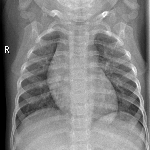

In [129]:
train_imgs_scaled = train_imgs.astype('float32') 
validation_imgs_scaled = validation_imgs.astype('float32') 
train_imgs_scaled /= 255 
validation_imgs_scaled /= 255 
 
# visualize a sample image 
print(train_imgs[0].shape) 
array_to_img(train_imgs[0]) 

'covid (112)'

In [139]:
for i in range(200):
    if train_labels[i].find("sano")==-1:
        train_labels[i]='covid'
    else :
        train_labels[i]='sano'
for i in range(40):
    if validation_labels[i].find("sano")==-1:
        validation_labels[i]='covid'
    else :
        validation_labels[i]='sano'
        

In [136]:
train_labels[199]

'sano'

In [140]:
batch_size = 30 
num_classes = 2 
epochs = 30 
input_shape = (150, 150, 3) 
 
# encode text category labels 
from sklearn.preprocessing import LabelEncoder 
 
le = LabelEncoder() 
le.fit(train_labels) 
train_labels_enc = le.transform(train_labels) 
validation_labels_enc = le.transform(validation_labels) 
 
print(train_labels[190:195], train_labels_enc[195:200]) 

['sano', 'sano', 'sano', 'sano', 'sano'] [1 1 1 1 1]


In [141]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3,  
                                   rotation_range=50, 
                                   width_shift_range=0.2,  
                                   height_shift_range=0.2,   
                                   shear_range=0.2,  
                                   horizontal_flip=True,   
                                   fill_mode='nearest') 
 
val_datagen = ImageDataGenerator(rescale=1./255) 

In [142]:
from keras.applications import vgg16 
from keras.models import Model 
import keras 
 
vgg = vgg16.VGG16(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

# we have removed the final part of the classifier pertaining to the VGG-16 model 
#since we will be building our own classifier and leveraging VGG as a feature extractor
output = vgg.layers[-1].output 
output = keras.layers.Flatten()(output) 
vgg_model = Model(vgg.input, output) 
vgg_model.trainable = False 
 
for layer in vgg_model.layers: 
    layer.trainable = False 

vgg_model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [143]:
# To verify that the layers of the VGG-16 model are frozen, we can use the following code:
import pandas as pd 
pd.set_option('max_colwidth', -1) 
 
layers = [(layer, layer.name, layer.trainable) for layer in 
           vgg_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

c:\users\hecto\downloads\machinecrypto\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x00000244CE250D48>,input_1,False
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x00000244CE154D48>,block1_conv1,False
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x00000244C0F3FEC8>,block1_conv2,False
3,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x00000244CDFF8748>,block1_pool,False
4,<keras.layers.convolutional.conv2d.Conv2D object at 0x00000244CE052AC8>,block2_conv1,False
5,<keras.layers.convolutional.conv2d.Conv2D object at 0x00000244CE15A9C8>,block2_conv2,False
6,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x00000244CE131FC8>,block2_pool,False
7,<keras.layers.convolutional.conv2d.Conv2D object at 0x00000244CE129C08>,block3_conv1,False
8,<keras.layers.convolutional.conv2d.Conv2D object at 0x00000244CE11DF88>,block3_conv2,False
9,<keras.layers.convolutional.conv2d.Conv2D object at 0x00000244CE29F3C8>,block3_conv3,False


In [144]:
print("Trainable layers:", vgg_model.trainable_weights)


Trainable layers: []


1/1 [==============================] - 0s 194ms/step
(1, 4, 4, 512)


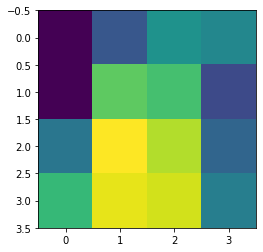

In [145]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape) 
plt.imshow(bottleneck_feature_example[0][:,:,0]) 

In [146]:
def get_bottleneck_features(model, input_imgs): 
    features = model.predict(input_imgs, verbose=0) 
    return features 

train_features_vgg = get_bottleneck_features(vgg_model, 
                                             train_imgs_scaled) 
validation_features_vgg = get_bottleneck_features(vgg_model,      
                                                validation_imgs_scaled) 

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape) 

Train Bottleneck Features: (200, 8192) 	Validation Bottleneck Features: (40, 8192)


In [147]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

In [149]:
model = BaggingClassifier(
base_estimator=DecisionTreeClassifier(), 
n_estimators=5
)

In [155]:
history = model.fit(train_features_vgg, y=train_labels_enc)

In [157]:
scores = cross_val_score(BaggingClassifier(
base_estimator=DecisionTreeClassifier(), 
n_estimators=5
), train_features_vgg ,train_labels_enc, cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
scores.mean()

0.93 accuracy with a standard deviation of 0.06


0.9299999999999999

In [162]:
f1_score(validation_labels_enc,history.predict(validation_features_vgg))

0.9743589743589743